# Imports

In [1]:
import joblib
import torch
import pandas as pd
import numpy as np
import CNN.network
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, matthews_corrcoef, cohen_kappa_score
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

## Load the models

In [2]:

decision_tree_model = joblib.load("./DecisionTree/decision_tree.joblib")
random_forest_model = joblib.load("./RandomForest/random_forest.joblib")
knn_model = joblib.load("./KNN/KNN.joblib")

cnn_model = CNN.network.Net()
cnn_model.load_state_dict(torch.load("./CNN/network_newest.net", weights_only=True))


<All keys matched successfully>

## Test dataset preparation

In [3]:
from KNN.dataset import SklearnDataset, CustomImageDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

sample_size = 0.2
image_size_tabular = (64, 64)
image_size_cnn = (32, 32)
annotations_file = "./data/png/test/labels.csv"
img_dir = "./data/png/test/"


labels = pd.read_csv(annotations_file)

image_filenames = labels.iloc[:, 0]
y_true = labels.iloc[:, 1].values

cnn_transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
])

dataset_tabular = SklearnDataset(
    annotations_file=annotations_file,
    img_dir=img_dir,
    image_size=image_size_tabular,
    augment=True
)

dataset_cnn = CustomImageDataset(
    annotations_file=annotations_file,
    img_dir=img_dir,
    transform=cnn_transform
)
test_dataloader = DataLoader(dataset_cnn, batch_size=64, shuffle=True, num_workers=4)

images = []
labels = []
X_test_cnn = []


for filename in image_filenames:
    image = Image.open(f"./data/png/test/{filename}")
    image_transformed_cnn = cnn_transform(image)
    X_test_cnn.append(image_transformed_cnn)


for i in range(len(dataset_tabular)):
    image, label = dataset_tabular[i]
    images.append(image)
    labels.append(label)


X_test_scikit = np.array(images)
y_true_sample = np.array(labels)




## Sample data visualization

/tmp/ipykernel_118547/804283570.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts_sample.index, y=class_counts_sample.values, palette="viridis")


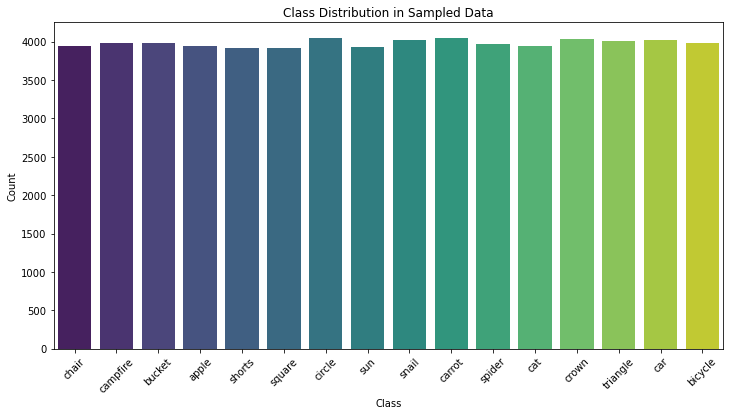

In [4]:
class_counts_sample = pd.Series(y_true_sample).value_counts().sort_index()

label_key = {
    0: 'chair', 1: 'campfire', 2: 'bucket', 3: 'apple', 4: 'shorts', 5: 'square', 
    6: 'circle', 7: 'sun', 8: 'snail', 9: 'carrot', 10: 'spider', 
    11: 'cat', 12: 'crown', 13: 'triangle', 14: 'car', 15: 'bicycle'
}
class_counts_sample.index = class_counts_sample.index.map(label_key)

plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts_sample.index, y=class_counts_sample.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Class Distribution in Sampled Data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## Predictions

In [5]:

X_test_images = torch.stack(X_test_cnn )


from sklearn.decomposition import PCA
pca = joblib.load("./KNN/pca_model.joblib")
X_train_pca = pca.fit_transform(X_test_scikit)

evaluation_times = {}

start_time = time.time()
y_pred_dt = decision_tree_model.predict(X_train_pca)
evaluation_times['Decision Tree'] = time.time() - start_time

start_time = time.time()
y_pred_rf = random_forest_model.predict(X_train_pca)
evaluation_times['Random Forest'] = time.time() - start_time


start_time = time.time()
y_pred_knn = knn_model.predict(X_train_pca)
evaluation_times['KNN'] = time.time() - start_time

cnn_model.eval()
start_time = time.time()
with torch.no_grad():
    cnn_outputs = cnn_model(X_test_images)
    _, y_pred_cnn = torch.max(cnn_outputs, 1)
    y_pred_cnn = y_pred_cnn.numpy()
evaluation_times['CNN'] = time.time() - start_time


## Evaluation function

In [10]:
from sklearn.metrics import root_mean_squared_error
def evaluate_metrics(y_true, y_pred, model_name="Model"):
    print(f"\nPerformance metrics for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.3f}")
    print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted'):.3f}")
    print(f"RMSE: {root_mean_squared_error(y_true, y_pred):.3f}")
    print(f"Evaluation Time: {evaluation_times[model_name]:.4f} seconds")
    print("\n")



## Evaluation

In [11]:
evaluate_metrics(y_true_sample, y_pred_knn, model_name="KNN")
evaluate_metrics(y_true_sample, y_pred_dt, model_name="Decision Tree")
evaluate_metrics(y_true_sample, y_pred_rf, model_name="Random Forest")
evaluate_metrics(y_true_sample, y_pred_cnn, model_name="CNN")


Performance metrics for KNN:
Accuracy: 0.459
Recall: 0.459
F1 Score: 0.456
RMSE: 4.691
Evaluation Time: 34.5888 seconds



Performance metrics for Decision Tree:
Accuracy: 0.339
Recall: 0.339
F1 Score: 0.343
RMSE: 5.448
Evaluation Time: 0.0145 seconds



Performance metrics for Random Forest:
Accuracy: 0.549
Recall: 0.549
F1 Score: 0.554
RMSE: 4.668
Evaluation Time: 0.4288 seconds



Performance metrics for CNN:
Accuracy: 0.954
Recall: 0.954
F1 Score: 0.954
RMSE: 1.322
Evaluation Time: 12.5079 seconds




## Visualize

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def draw_confusion_matrix(y_true, y_preds, model_names):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for ax, y_pred, model_name in zip(axes, y_preds, model_names):
        cm = confusion_matrix(y_true, y_pred)
        vmax = cm.max()
        vmin = cm.min()

        sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', ax=ax, cbar=True, vmin=vmin, vmax=vmax)
        
        ax.set_title(f"Predicted vs true labels for {model_name}")
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
    
    plt.tight_layout

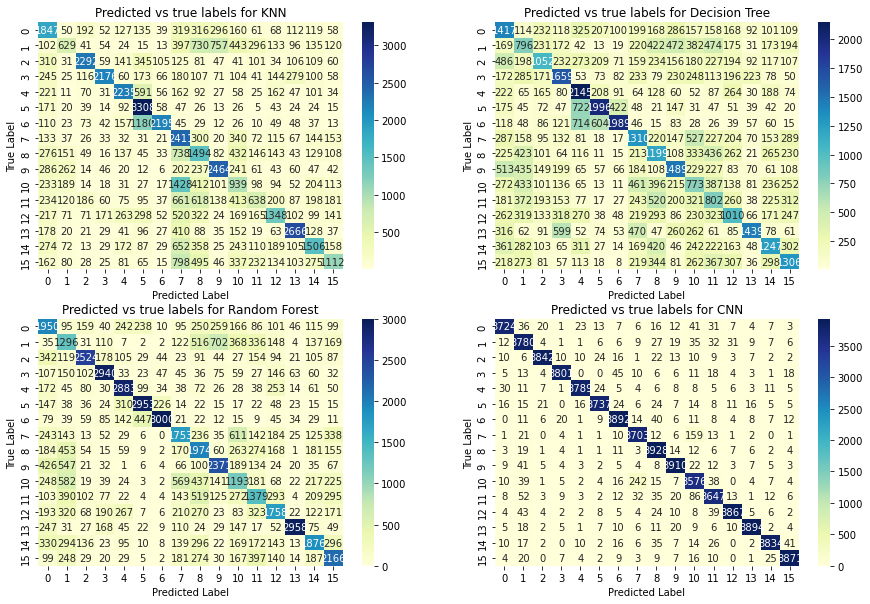

In [9]:
y_preds = [y_pred_knn, y_pred_dt, y_pred_rf, y_pred_cnn]
model_names = ["KNN", "Decision Tree", "Random Forest", "CNN"]
draw_confusion_matrix(y_true_sample, y_preds, model_names)